# Exploratory Data Analysis (EDA):

In this notebook you'll find part of the EDA of the thesis **Temporal Clustering of Citizen-Contributed Data for Air Pollution Pattern Recognition**. Even thought that this notebook doesn't contain all the analysis that has to be done with the given data, it is a starting poing for understanding the dataset and make it suitable for the project.

### Objective of the EDA

The main goal of this EDA is to get enough insights to be able to transform the original longitudinal data into a multivariate timeseries that includes all the possible information so it can be used as an input for different models.

![title](img/template.png)

All the features will be normalized from 0 to 1 so they have the same importance when calculating the distances in the clustering

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
from scipy.stats import lognorm, trim_mean
import math
import numpy as np

In [29]:
#We read raw smell reports' longitudinal data
data = pd.read_csv("smell_raw.csv")

#We get the date in a human-readable format (Pittsburgh's time zone is New York's as well)
tz = pytz.timezone('America/New_York')
data["date"] = data["EpochTime"].apply(lambda epoch : datetime.fromtimestamp(epoch, tz).strftime('%Y-%m-%d'))
data.tail(1)

,EpochTime,skewed_latitude,skewed_longitude,smell_value,smell_description,feelings_symptoms,additional_comments,zipcode,date
79852,1670730335,40.3177,-80.0523,4,Pittsburgh,NaN,NaN,15102,2022-12-10


### Overview of the longitudinal data:

Goals: Visualization of the data, description of the features, get missing values,...

In [30]:
print(f"The dataframe has {data.shape[0]} reports.")
total_reports = data.shape[0]
avg =  data.shape[0] / (datetime.strptime(data['date'].max(), "%Y-%m-%d") - datetime.strptime(data['date'].min(), "%Y-%m-%d")).days
print(f"Those reports go from {data['date'].min()} to {data['date'].max()}. An average of {round(avg, 1)} reports per day")
print(f"The most common intensity report is {data['smell_value'].value_counts().idxmax()}")
print(f"The average intensity report is {round(data['smell_value'].mean(), 2)}")

print("\nAdditional data: (percentage of reports that include it)")
print(f"Smell Description: {100 - round(data['smell_description'].isna().sum()/total_reports * 100, 2)}%")
print(f"Feeling Symptoms: {100 - round(data['feelings_symptoms'].isna().sum()/total_reports * 100, 2)}%")
print(f"Additional data: {100 - round(data['additional_comments'].isna().sum()/total_reports * 100, 1)}%")

The dataframe has 79853 reports.
Those reports go from 2016-10-31 to 2022-12-10. An average of 35.8 reports per day
The most common intensity report is 4
The average intensity report is 3.66

Additional data: (percentage of reports that include it)
Smell Description: 70.12%
Feeling Symptoms: 35.05%
Additional data: 17.5%


### Visualization of the data as a daily time-series

<Figure size 640x1000 with 0 Axes>

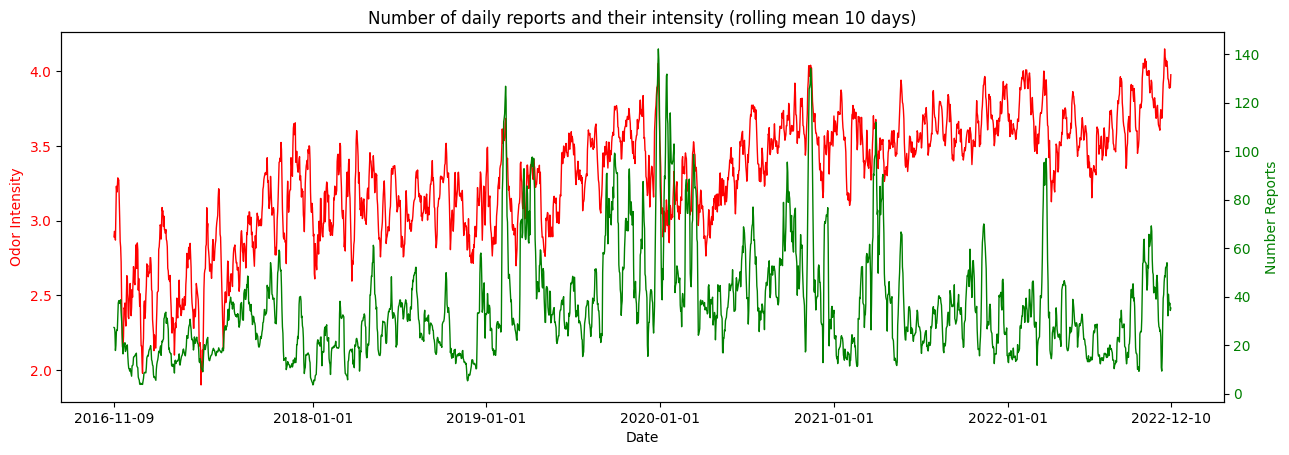

In [31]:
# The longitudinal data is tranformed to a time-series
ts_data = data.groupby("date").agg({"smell_value": ['mean', 'count', 'median']})
ts_data.columns = ts_data.columns.droplevel(0)

rolling_mean = 10
# Mean smell intensity in rolling 10 dats and total number of reports
smell_intensity = ts_data['mean'].rolling(rolling_mean).mean()
num_entries = ts_data['count'].rolling(rolling_mean).mean()
date = list(smell_intensity.keys())

plt.figure().set_figheight(10)
plt.figure().set_figwidth(15)

# Creating first Axe of the plot
ax1 = plt.subplot()
ax1.set_xlabel("Date")
l1, = ax1.plot(date, smell_intensity, color='red', lw=1, label="smell intensity")
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_ylabel("Odor Intensity", color='red')
# Creating second Axe of plot
ax2 = ax1.twinx()
l2, = ax2.plot(date, num_entries, color='green', lw=1, label="reports per day")
ax2.tick_params(axis='y', labelcolor='green')
ax2.set_ylabel("Number Reports", color='green')

ax2.set_xticks([date[rolling_mean-1], '2018-01-01', '2019-01-01', '2020-01-01', '2021-01-01', '2022-01-01', date[-1]])
plt.title("Number of daily reports and their intensity (rolling mean 10 days)")
plt.show()


### Feature Engineering experiments

In this sections we will justify all the possible questions we assume in order to create the multivariate time series.

#### How should the aggregation be done. Daily. Twice a day. Three times a day,...

<AxesSubplot: xlabel='hour', ylabel='Count'>

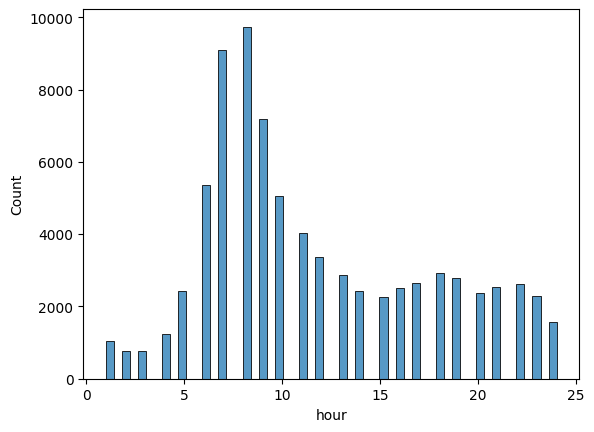

In [32]:
def hour(epoch):
    hour = datetime.utcfromtimestamp(3600 * ((epoch + 1800) // 3600)).hour - 5

    return hour if hour > 0 else hour + 24

data_hourly = data.copy()
data_hourly["hour"] = data_hourly['EpochTime'].apply((lambda epoch: hour(epoch)))

sns.histplot(data_hourly["hour"])

As there is only one peak at the beginning of the day (from 06:00 to 10:00) getting the aggregate per day (24 hours) will is the most.

However if we divide the data in days we'll only have around 2000 datapoints and that may not be enough for a Neural Network. Therefore more datapoints will be created by aggregating 24-hours-data with a window of 5 hours.

In [33]:
def windowed_timeseries(data, window_size = 5):
    window_data = []
    end = data['EpochTime'].max()
    start = data['EpochTime'].min()
    i = 0
    
    while start < end:
        window_data.append(create_window_row(data, start))
        start += window_size * 3600
    
    return pd.DataFrame(window_data)

def create_window_row(data, epoch_start: int, agg_size = 24):
    epoch_finish = epoch_start + agg_size * 3600
    filtered = data.loc[(data['EpochTime'] >= epoch_start) & (data['EpochTime'] < epoch_finish)]['smell_value']
    
    dict = {
        "EpochStart" : epoch_start,
        "EpochEnds"  : epoch_finish,
        "Date"       : datetime.fromtimestamp(epoch_start, tz).strftime('%Y-%m-%d'),
        "Hour"       : datetime.fromtimestamp(epoch_finish, tz).strftime('%H'),
        "AvgSmell"   : trim_mean(filtered, 0.1),
        "NumReports" : filtered.count()
    }

    return dict

ts_data = windowed_timeseries(data)
print(f"Number of datapoints: {ts_data.shape[0]}")

Number of datapoints: 10711


#### About the Smell Intensity and the number of daily reports

In the description of the dataset we say that the average report was 3'66. Even though the city of Pittsburgh have a problem with pollution most of the days the odor is not noticeable. Hence, this number makes us think that users only report the smell when they smell a strong and bad odour.

<AxesSubplot: xlabel='NumReports', ylabel='Count'>

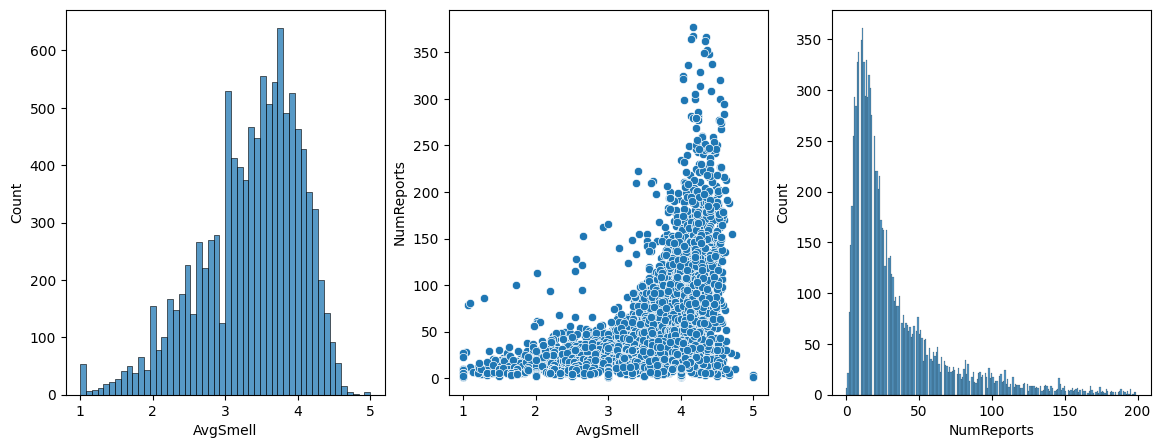

In [34]:
fig, ax =plt.subplots(1,3, figsize=(14, 5))

sns.scatterplot(data=ts_data, x='AvgSmell', y='NumReports', ax=ax[1])
sns.histplot(data=ts_data['AvgSmell'], bins = 50, ax=ax[0])
sns.histplot(data=ts_data[ts_data['NumReports'] < 200]['NumReports'], bins = 220, ax=ax[2])


As stated, the distribution of the smell reports is not normal and the median is arround the upper half. (1st Figure)
Moreover there is a slight correlation between the average smell report and the number of reports in a day -people report more when there's strong odors.(2nd Figure) This means that the number of reports, that follow a log-normal distribution (3rd Figure), can also be a good reference for estimate the intesity of the smell.

The proposed metric (y) follows this formula where x1 is the average smell report in that period of time and x2 the number of reports:

$$ y = ln(x1)/ln(5) * P(X <= x2)$$

This way we have a normalized metric (from 0 to 1) that values when both x1 and x2 are high. This way we can avoid false positives like having very few people reporting a strong odor.

![title](img/heatmap.png)


<AxesSubplot: >

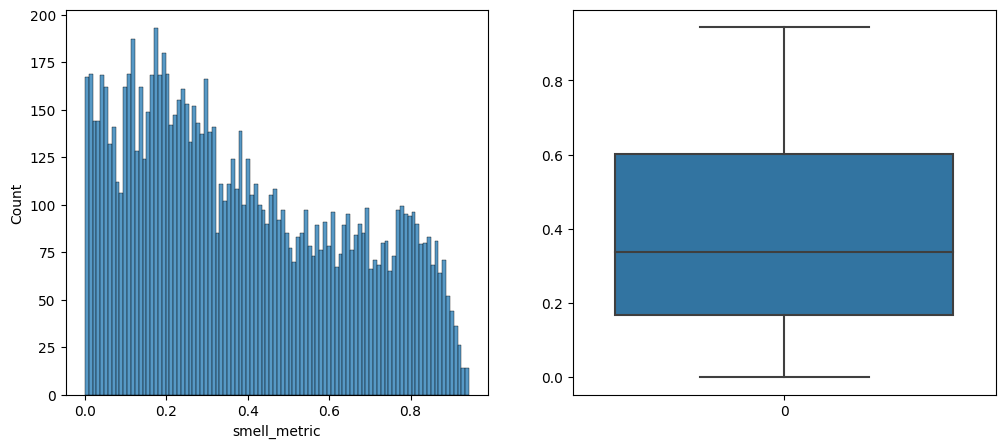

In [35]:
def log(x):
    return 0 if x == 0 else np.log(x)
    
missing_data = len(ts_data[ts_data['NumReports'] < 1])
n = ts_data.shape[0] - missing_data
mu = ts_data['NumReports'].apply(lambda count: log(count)).sum() / n
sigma = np.sqrt(ts_data['NumReports'].apply(lambda count: (log(count) - mu)**2).sum() / (n - 1))

def cdf(x):
    return lognorm(s=sigma, scale=math.exp(mu)).cdf(x)

def custom_metric(avg_mean, num_reports, max_intensity_score = np.log(5)):
    mean_score = np.log(avg_mean)/max_intensity_score
    reports_score = cdf(num_reports)

    return mean_score * reports_score


ts_data["smell_metric"] = ts_data.apply(lambda df: custom_metric(df.AvgSmell, df.NumReports), axis=1)

fig, ax = plt.subplots(1,2, figsize=(12, 5))

sns.histplot(data=ts_data['smell_metric'], bins = 100, ax=ax[0])
sns.boxplot(data=ts_data['smell_metric'], ax=ax[1])

In [36]:
for i in range (0, 11):
    i = i * 10
    new_data = ts_data.loc[(ts_data['NumReports'] >= i) & (ts_data['NumReports'] < i + 10)]
    print(f"Avg. report intensity in days with [{i} - {i + 10}) reports, Avg. intensity: {round(new_data['AvgSmell'].mean(), 4)}, New metric: {round(new_data['smell_metric'].mean(), 6)})")

Avg. report intensity in days with [0 - 10) reports, Avg. intensity: 2.8945, New metric: 0.064501)
Avg. report intensity in days with [10 - 20) reports, Avg. intensity: 3.1256, New metric: 0.220226)
Avg. report intensity in days with [20 - 30) reports, Avg. intensity: 3.2936, New metric: 0.384723)
Avg. report intensity in days with [30 - 40) reports, Avg. intensity: 3.4867, New metric: 0.512257)
Avg. report intensity in days with [40 - 50) reports, Avg. intensity: 3.6512, New metric: 0.609155)
Avg. report intensity in days with [50 - 60) reports, Avg. intensity: 3.7632, New metric: 0.671206)
Avg. report intensity in days with [60 - 70) reports, Avg. intensity: 3.866, New metric: 0.72139)
Avg. report intensity in days with [70 - 80) reports, Avg. intensity: 3.9514, New metric: 0.759051)
Avg. report intensity in days with [80 - 90) reports, Avg. intensity: 3.9768, New metric: 0.78008)
Avg. report intensity in days with [90 - 100) reports, Avg. intensity: 3.9475, New metric: 0.793032)
Avg

In order to get more insights of the reports through the location, we calculate whether the locations were focused in one area or were more dispersed.

<AxesSubplot: xlabel='dispersion', ylabel='Count'>

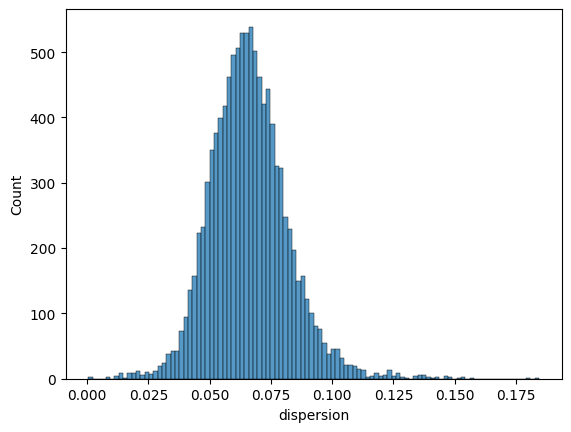

In [38]:
def get_sparsity(epochstart, epochend):
    filtered = data.loc[(data["EpochTime"] >= epochstart) & (data["EpochTime"] < epochend)]
    return np.mean((filtered['skewed_latitude'].std(), filtered['skewed_longitude'].std()))

ts_data["dispersion"] = ts_data.apply(lambda row: get_sparsity(row["EpochStart"], row["EpochEnds"]), axis = 1)
sns.histplot(ts_data["dispersion"])

#### Which features can we extract from the text-inputs.

<AxesSubplot: xlabel='frequency', ylabel='word'>

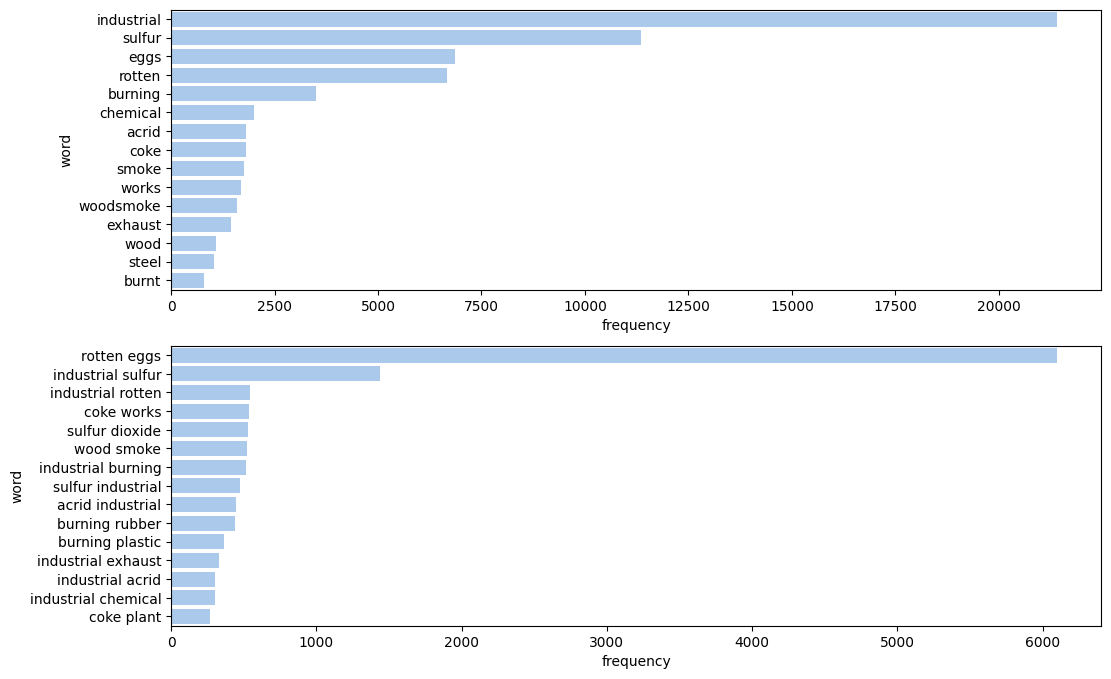

In [40]:
from collections import defaultdict
from itertools import islice
import re

def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return pd.DataFrame(list(islice(iterable, n)), columns=['word', 'frequency'])

def normalize(word):
    if word == 'sulphur':
        return 'sulfur'
    elif word == 'egg':
        return 'eggs'
    else:
        return word

stopwords = ['and', 'like', 'clairton', '', 'of', 'from', 'smells', 'smell', 'the', 'a', 'us', 'in', 'stench', 'air']

inputs = data['smell_description'].dropna().values
tokens = defaultdict(int)
bigram_tokens = defaultdict(int)

for ind_input in inputs:
    document = ind_input.split()
    previous = ""
    for token in document:
        current = normalize(re.sub(r'[^\w]', "", token.lower()))
        if current not in stopwords:
            tokens[current] += 1
        if previous != "":
            if current not in stopwords and previous not in stopwords:
                bigram = previous + " " + current
                bigram_tokens[bigram] += 1
                previous = current
        else:
            previous = re.sub(r'[^\w]', "", token.lower())

tokens = take(15, {k: v for k, v in sorted(tokens.items(), key=lambda item: item[1], reverse=True)}.items())
bigrams = take(15, {k: v for k, v in sorted(bigram_tokens.items(), key=lambda item: item[1], reverse=True)}.items())

fig, ax =plt.subplots(2,1, figsize=(12, 8))
sns.barplot(x="frequency", y="word", data=tokens, color='b', orient='h', ax=ax[0])
sns.barplot(x="frequency", y="word", data=bigrams, color='b',orient='h', ax=ax[1])

#### Wind






Wind in Feed_1_Avalon_ACHD has 29016 filled reports from 34965


<AxesSubplot: xlabel='3.feed_1.SONICWS_MPH', ylabel='Count'>

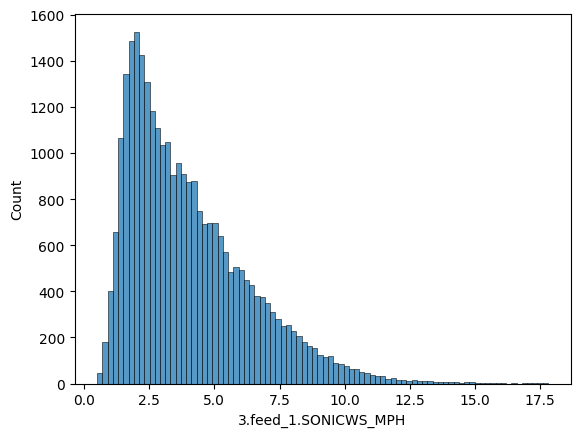

In [41]:
wind = pd.read_csv('./smell-pittsburgh-prediction/dataset/v2.1/esdr_raw/Feed_1_Avalon_ACHD.csv')
print(f"Wind in Feed_1_Avalon_ACHD has {wind['3.feed_1.SONICWS_MPH'].count()} filled reports from {wind.shape[0]}")
sns.histplot(wind['3.feed_1.SONICWS_MPH'].dropna())

<AxesSubplot: xlabel='3.feed_1.SONICWD_DEG', ylabel='Count'>

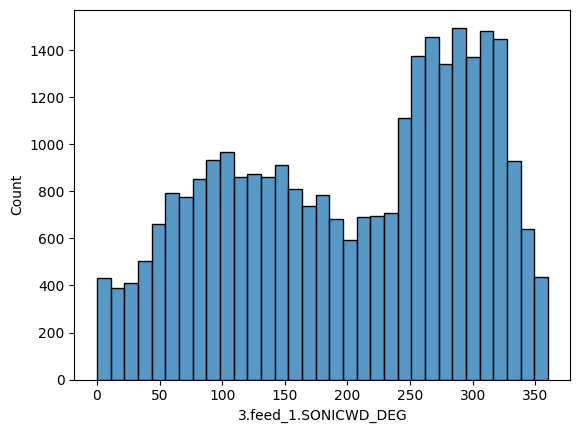

In [42]:
sns.histplot(wind['3.feed_1.SONICWD_DEG'].dropna())